In [1]:

import gym
env = gym.make('CartPole-v0')

import numpy as np

class LogisticPolicy:
    
    def __init__(self, θ, α, γ):
        # Initialize paramters θ, learning rate α and discount factor γ
        
        self.θ = θ
        self.α = α
        self.γ = γ
        
    def logistic(self, y):
        # definition of logistic function
        
        return 1/(1 + np.exp(-y))
    
    def probs(self, x):
        # returns probabilities of two actions
        
        y = x @ self.θ
        prob0 = self.logistic(y)
        
        return np.array([prob0, 1-prob0])        
    
    def act(self, x):
        # sample an action in proportion to probabilities
        
        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)
        
        return action, probs[action]
    
    def grad_log_p(self, x):
        # calculate grad-log-probs
        
        y = x @ self.θ        
        grad_log_p0 = x - x*self.logistic(y)
        grad_log_p1 = - x*self.logistic(y)
        
        return grad_log_p0, grad_log_p1
        
    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # dot grads with future rewards for each action in episode
        
        return grad_log_p.T @ discounted_rewards
    
    def discount_rewards(self, rewards):
        # calculate temporally adjusted, discounted rewards
        
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards
            
        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob,action in zip(obs,actions)])
        
        assert grad_log_p.shape == (len(obs), 4)
        
        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)
        
        # gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)
        
        # gradient ascent on parameters
        self.θ += self.α*dot

In [2]:
def run_episode(env, policy, render=False):
    
    observation = env.reset()
    totalreward = 0
    
    observations = []
    actions = []
    rewards = []
    probs = []
    
    done = False
    
    while not done:
        if render:
            env.render()
        
        observations.append(observation)
        
        action, prob = policy.act(observation)
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)
    
    return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)

In [3]:
def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=False):
    
    # initialize environment and policy
    env = gym.make('CartPole-v0')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)
    
    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):

        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, policy)
                
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        
        # update policy
        policy.update(rewards, observations, actions)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False) 

    # evaluation call after training is finished - evaluate last trained policy on 100 episodes
    if evaluate:
        env = Monitor(env, 'pg_cartpole/', video_callable=False, force=True)
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()
        
    return episode_rewards, policy

In [5]:
from gym.wrappers.monitor import Monitor, load_results

# for reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=2000,
                                seed=GLOBAL_SEED,
                                evaluate=True)

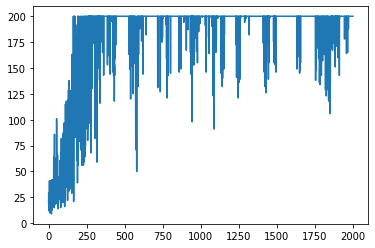

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(episode_rewards);

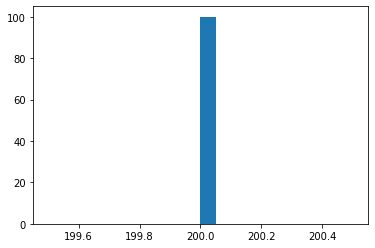

In [10]:
results = load_results('pg_cartpole')
plt.hist(results['episode_rewards'], bins=20);

In [11]:
state=env.reset()

In [13]:
while True:
    
    action, prob = policy.act(state)
    state, reward, done, info = env.step(action)
    env.render()

/opt/anaconda3/lib/python3.7/site-packages/gym/envs/classic_control/cartpole.py:151: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


KeyboardInterrupt: 

In [ ]:
env.reset()